In [101]:
import collections

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import microstructpy as msp
import meshio

In [2]:
domain = msp.geometry.Square(corner=(0, 0))

In [3]:
factory = msp.seeding.Seed.factory
n = 200
seeds = msp.seeding.SeedList([factory('circle', r=0.007) for i in range(n)])

In [4]:
lims = np.array(domain.limits) * (1 - 1e-5)
centers = np.zeros((n, 2))

for i in range(n):
    f = np.random.rand(i + 1, 2)
    pts = f * lims[:, 0] + (1 - f) * lims[:, 1]
    try:
        min_dists = scipy.spatial.distance.cdist(pts, centers[:i]).min(axis=1)
        i_max = np.argmax(min_dists)
    except ValueError:  # this is the case when i=0
        i_max = 0
    centers[i] = pts[i_max]
    seeds[i].position = centers[i]

In [83]:
propphase = 0.2
pmesh = msp.meshing.PolyMesh.from_seeds(seeds, domain)
nsecond = np.random.choice(len(seeds), size=int(len(seeds)*propphase), replace=False)
pmesh.phase_numbers = np.array(pmesh.phase_numbers)
pmesh.phase_numbers[nsecond] = 1

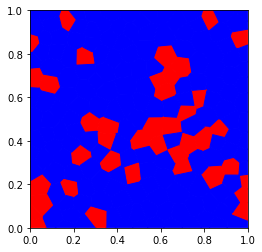

In [84]:
pmesh.plot(index_by='material', color=['blue', 'red'])

In [85]:
tmesh = msp.meshing.TriMesh.from_polymesh(pmesh,
                                          min_angle=30,
                                          max_edge_length=0.05,
                                          max_volume=0.2)

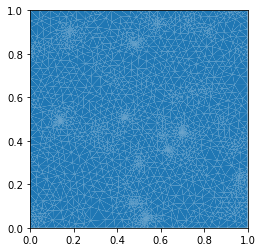

In [86]:
tmesh.plot()

In [87]:
def vectorized_query(query_list, ordered_list):
    # Step 1: Record the original shape for later reshaping
    original_shape = query_list.shape
    
    # Step 2: Flatten the query list to 1D
    query_list_flat = query_list.ravel()

    # Step 3: Perform the vectorized mapping
    arr = np.array(ordered_list)
    indices = np.searchsorted(arr, query_list_flat, side='left')
    indices[indices == len(arr)] = -1  # For elements greater than the max in arr
    mask = (arr[indices] != query_list_flat)
    indices[mask] = -1  # For elements not found in arr
    
    # Step 4: Reshape to the original shape
    indices = indices.reshape(original_shape)
    
    return indices

# Testing
l = [0, 2, 3, 4]
query = np.array([[2, 0], [3, 1]])
result = vectorized_query(query, l)
print(result)  # Output should be [[1, 0], [2, -1]]

[[ 1  0]
 [ 2 -1]]


In [139]:
def extract_line_elements(triangle_elements):
    line_elements_counter = collections.defaultdict(lambda : list())
    for j, triangle in enumerate(triangle_elements):
        for i in range(3):
            # Extract the vertices of each edge and sort them to ensure uniqueness
            edge = tuple(sorted([triangle[i], triangle[(i + 1) % 3]]))
            line_elements_counter[edge].append(j)
    line_elements = np.vstack(list(line_elements_counter.keys()))
    return line_elements, line_elements_counter
points = tmesh.points
triangle_elements = tmesh.elements
cells_attributes = tmesh.element_attributes
new_elements_indexes = pmesh.phase_numbers[cells_attributes] == 0
new_elements = triangle_elements[new_elements_indexes, :]
new_point_indexes = np.unique(new_elements.flatten())
new_points = points[new_point_indexes, :]
new_triangle_elements = vectorized_query(new_elements, new_point_indexes)
new_line_elements, line_elements_counter = extract_line_elements(new_elements)
new_boundary_elements = [i for i, el in enumerate(new_line_elements)
                         if len(line_elements_counter[tuple(el)]) == 1]

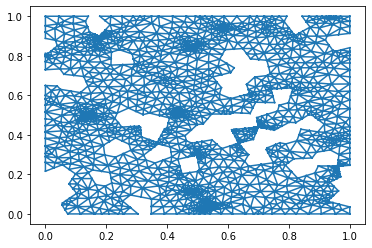

In [140]:
plt.triplot(new_points[..., 0], new_points[..., 1], triangles=new_triangle_elements)

In [141]:
boundary_maps = [(1, 0, 0.0), (2, 0, 1.0), (3, 1, 0.0), (4, 1, 1.0)]
def get_boundary_attributes(line_elements, outer_elements, points):
    line_attributes = np.zeros(line_elements.shape[0], dtype='int')
    line_attributes[outer_elements] = 5
    for m, i, v in boundary_maps:
        inds = [j for j in range(line_elements.shape[0])
                if np.all(np.isclose(points[line_elements[j], i], v))]
        line_attributes[inds] = m
    return line_attributes

In [142]:
line_attributes = get_boundary_attributes(new_line_elements, new_boundary_elements, points)
triangle_attributes = cells_attributes[new_elements_indexes]

In [144]:
cells = [
    meshio.CellBlock("line", new_line_elements),
    meshio.CellBlock("triangle", new_triangle_elements),
]

cell_data_dict = {
    "grain": [  # Replace with the actual attribute name
        np.array(line_attributes),
        np.array(triangle_attributes),
    ]
}

mesh = meshio.Mesh(
    points=new_points,
    cells=cells,
    cell_data=cell_data_dict,
)
meshio.write("microstructure_mesh.vtk", mesh)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.